### Imports

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### OCV vs. SOC Data

In [55]:
# Format the data
_ = pd.read_csv('./data/SOC_OCV_MFCTT_2019.csv', sep='\t', names=['SOC', 'Ecell/V'], skiprows=1).astype(float)
_.to_csv('./data/SOC_OCV_MFCTT_2019_delim.csv', index=False)

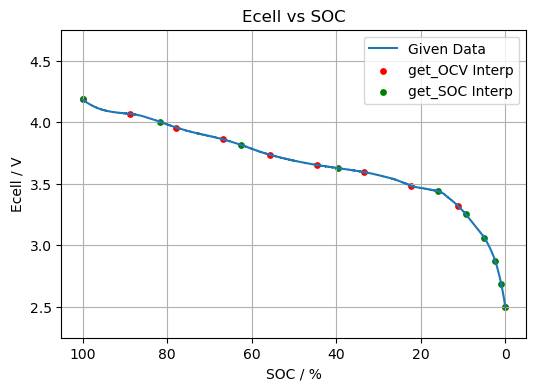

In [56]:
# Load the formatted OCV_DATA csv file
OCV_DATA = pd.read_csv('./data/SOC_OCV_MFCTT_2019_delim.csv')
SOC_DATA = OCV_DATA['SOC'].values
ECELL_DATA = OCV_DATA['Ecell/V'].values

# Returns the open circuit voltage of the battery as a function of the state of charge
def get_OCV(SOC):
    SOC_array = np.array(SOC)
    if np.any(SOC_array < 0) or np.any(SOC_array > 100):
        raise ValueError('SOC must be between 0 and 100')
    # Linear interpolation of the data
    return np.interp(SOC_array, SOC_DATA[::-1], ECELL_DATA[::-1])

# Returns the state of charge of the battery as a function of the open circuit voltage
def get_SOC(Ecell):
    Ecell_array = np.array(Ecell)
    if np.any(Ecell_array < 2.5) or np.any(Ecell_array > 4.2):
        raise ValueError('Ecell must be between 2.5 and 4.2')
    # Linear interpolation of the data
    return np.interp(Ecell_array, ECELL_DATA[::-1], SOC_DATA[::-1])

# Demonstrate the function
SOC_interp1 = np.linspace(0, 100, 10)
Ecell_interp1 = get_OCV(SOC_interp1)

Ecell_interp2 = np.linspace(2.5, 4.19, 10)
SOC_interp2 = get_SOC(Ecell_interp2)

# Plot
fig = plt.figure(figsize=(6, 4))
plt.plot(OCV_DATA['SOC'], OCV_DATA['Ecell/V'], label='Given Data')
plt.scatter(SOC_interp1, Ecell_interp1, s=15, c='r', label='get_OCV Interp')
plt.scatter(SOC_interp2, Ecell_interp2, s=15, c='g', label='get_SOC Interp')
plt.title('Ecell vs SOC')
plt.xlabel('SOC / %')
plt.ylabel('Ecell / V')
plt.ylim(2.25, 4.75)
plt.gca().invert_xaxis() # Invert x-axis
plt.legend()
plt.grid()
plt.show()

### Thevenin Model

#### R0 Calculation

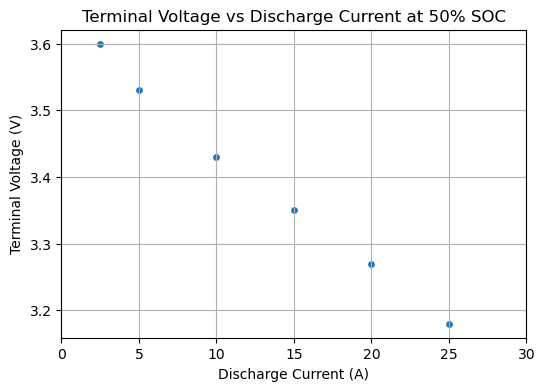

In [57]:
DISCHARGE_CURRENT_DATA = np.array([2.5, 5, 10, 15, 20, 25])
TERMINAL_VOLTAGE_DATA = np.array([3.60, 3.53, 3.43, 3.35, 3.27, 3.18])

# Plot
fig = plt.figure(figsize=(6, 4))
plt.scatter(DISCHARGE_CURRENT_DATA, TERMINAL_VOLTAGE_DATA, s=15)
plt.title('Terminal Voltage vs Discharge Current at 50% SOC')
plt.xlabel('Discharge Current (A)')
plt.ylabel('Terminal Voltage (V)')
plt.xlim(0, 30)
plt.grid()
plt.show()

In [58]:
current_diff = [i-DISCHARGE_CURRENT_DATA[0] for i in DISCHARGE_CURRENT_DATA[1:]]
voltage_diff = [v-TERMINAL_VOLTAGE_DATA[0] for v in TERMINAL_VOLTAGE_DATA[1:]]

resistances = np.abs(np.array(voltage_diff) / np.array(current_diff))
print(f'Resistances: {np.round(resistances, 3)} Ω')

R0 = resistances[-1]
print(f'R0 = {round(R0, 3)} Ω')

Resistances: [0.028 0.023 0.02  0.019 0.019] Ω
R0 = 0.019 Ω


### Battery Testing Data

       Time (s)  Current (mA)  Voltage (V)  Temperature
1           1.0           0.0         4.05        21.96
2           2.0           0.0         4.05        21.94
3           3.0           0.0         4.05        21.94
4           4.0           0.0         4.05        21.93
5           5.0           0.0         4.05        21.93
...         ...           ...          ...          ...
23427   23427.0           0.0         3.58        20.13
23428   23428.0           0.0         3.58        20.13
23429   23429.0           0.0         3.58        20.13
23430   23430.0           0.0         3.58        20.13
23431   23431.0           0.0         3.58        20.13

[23431 rows x 4 columns]


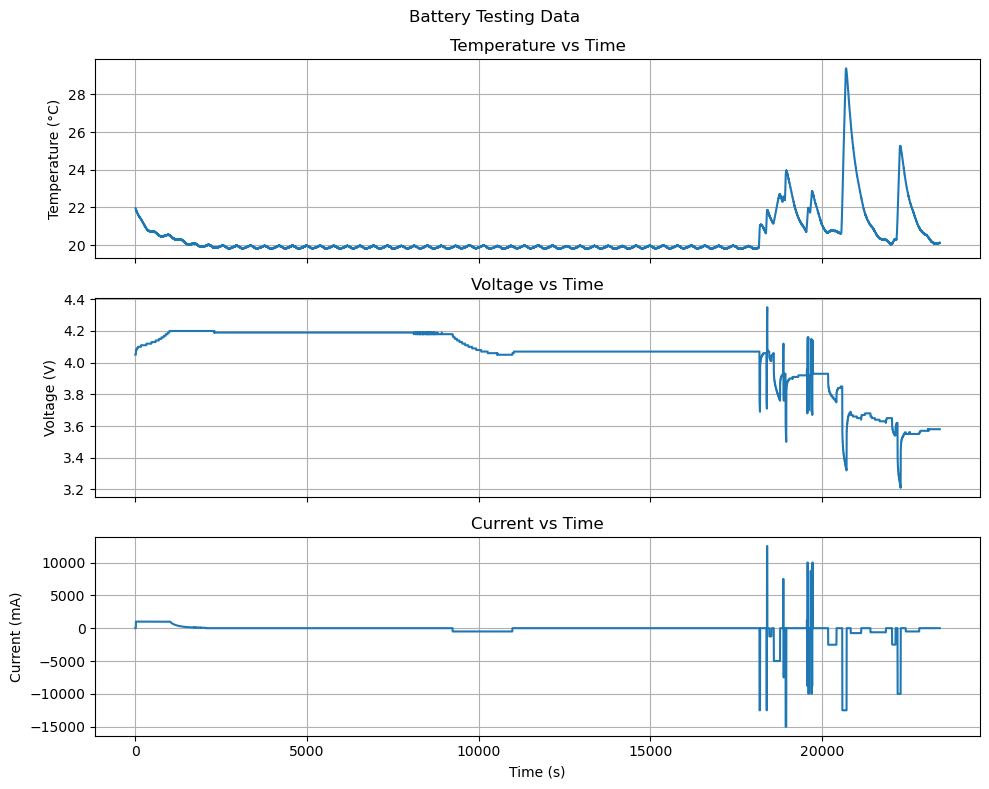

In [59]:
# Load data
BT_DATA = pd.read_csv('./data/Battery_Testing_Data.csv')
BT_DATA = BT_DATA.dropna()  # Drop NaN values
print(BT_DATA)

# Plot the data
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(BT_DATA['Time (s)'], BT_DATA['Temperature'])
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Temperature vs Time')

axs[1].plot(BT_DATA['Time (s)'], BT_DATA['Voltage (V)'])
axs[1].set_ylabel('Voltage (V)')
axs[1].set_title('Voltage vs Time')

axs[2].plot(BT_DATA['Time (s)'], BT_DATA['Current (mA)'])
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Current (mA)')
axs[2].set_title('Current vs Time')

for ax in axs:
    ax.grid(True)
plt.suptitle('Battery Testing Data')
plt.tight_layout()
plt.show()

#### Discharge Data

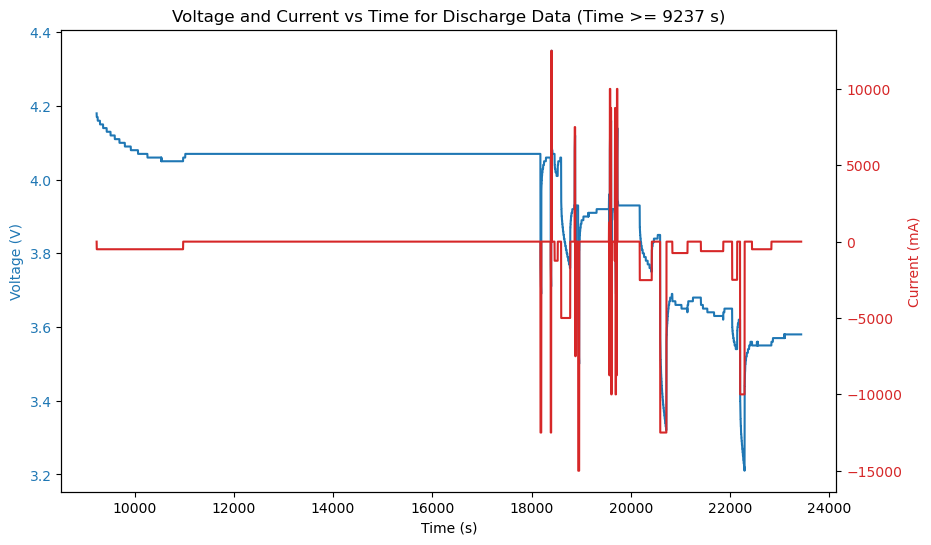

In [60]:
# Slice BT_discharge data
BT_discharge = BT_DATA[BT_DATA['Time (s)'] >= 9237]

# plot voltage and current in the same plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)', color='tab:blue')
ax1.plot(BT_discharge['Time (s)'], BT_discharge['Voltage (V)'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Current (mA)', color='tab:red')
ax2.plot(BT_discharge['Time (s)'], BT_discharge['Current (mA)'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Voltage and Current vs Time for Discharge Data (Time >= 9237 s)')
plt.show()

### Application

#### Calculate q(t) by Coulomb Counting

Starting SOC: 99.83 % at 4.18 V
Starting charge: 8984.37 C


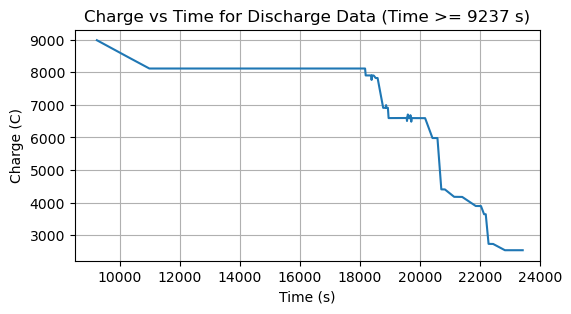

In [61]:
CAPACITY = 2500 # mAh
CAPACITY_C = CAPACITY * 3.6 # Coulombs

voltage_start = BT_discharge['Voltage (V)'].iloc[0]
SOC_start = get_SOC(voltage_start)
print(f"Starting SOC: {round(SOC_start, 2)} % at {voltage_start} V")

charge = CAPACITY * SOC_start/100 * 3.6 # Coulombs
print(f"Starting charge: {round(charge, 2)} C")

# Discharge data
dis_current_array = BT_discharge['Current (mA)'].values # mA
dis_voltage_array = BT_discharge['Voltage (V)'].values # V

# Coulomb counting
DT = 1 # sec
charge_array = [charge]
for i in range(1, len(dis_current_array)):
    charge += dis_current_array[i]/1000 * DT # C
    charge_array.append(charge)
charge_array = np.array(charge_array)

fig = plt.subplots(figsize=(6, 3))
plt.plot(BT_discharge['Time (s)'], charge_array)
plt.title('Charge vs Time for Discharge Data (Time >= 9237 s)')
plt.xlabel('Time (s)')
plt.ylabel('Charge (C)')
plt.xlim(8500, 24000)
plt.grid()
plt.show()

#### v_cell(t) = 

Initial T_cell = 19.89 °C
Ambient temperature = 19.89 °C
Initial R0 = 0.02 Ω
Initial R1 = 0.01 Ω
Initial v_term = 4.18 V


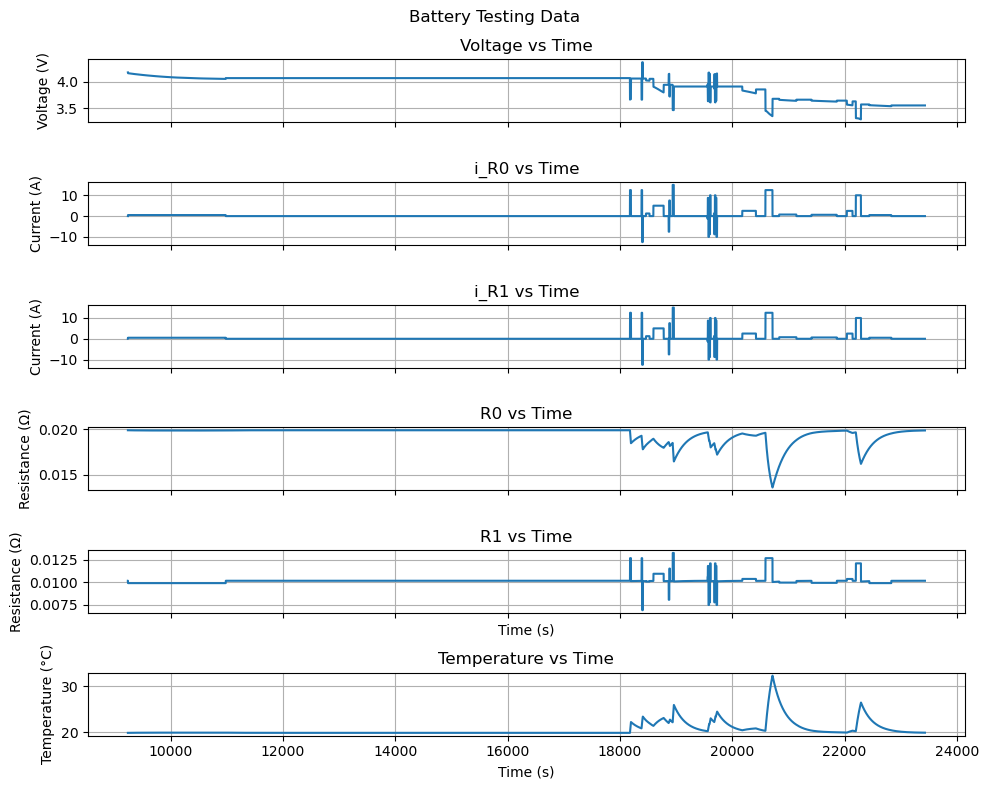

In [62]:
# Find initial temperature of cell
T_cell = np.zeros(len(BT_discharge))
T_cell[0] = BT_discharge['Temperature'].iloc[0] + 273.15
print(f'Initial T_cell = {np.round(T_cell[0] - 273.15, 2)} °C')

# Parameters
R0_T0 = 0.01987 # Ω
E0 = -22693

R1_0AT0 = 0.035 # Ω
C1 = 2.814 # kF
b = -0.6658
c = 0.09784
d = 0.00023
E1 = -27887

m = 0.042 # kg
cv = 825 # J/kgK

h = 15.7619 # W/m^2K
A = 0.018*np.pi*0.065 + 2*np.pi*0.065**2/4  # m^2 (surface area of 18650 battery)
T_amb = np.mean(BT_DATA['Temperature'][5000:9237]) + 273.15 # K
print(f'Ambient temperature = {np.round(T_amb - 273.15, 2)} °C')

# Resistance functions
def get_R0(T_cell): # T_cell in K, R0 in Ω
    return R0_T0 * np.exp(-E0/8.314*(1/T_cell-1/T_amb))

def get_R1(T_cell, i_R1): # T_cell in K, i_R1 in A, R1 in Ω
    return 0.0098 + d*i_R1 + R1_0AT0 * np.exp((-1*(i_R1-b)**2)/c) * np.exp(-E1/8.314*(1/T_cell-1/T_amb))

i_R0 = -BT_discharge['Current (mA)'].values / 1000
R0 = np.zeros(len(BT_discharge))
R0[0] = get_R0(T_cell[0])
print(f'Initial R0 = {np.round(R0[0], 3)} Ω')

i_R1 = np.zeros(len(BT_discharge))
R1 = np.zeros(len(BT_discharge))
R1[0] = get_R1(T_cell[0], i_R1[0])
print(f'Initial R1 = {np.round(R1[0], 3)} Ω')

SOC_array = charge_array/CAPACITY_C * 100
OCV_array = get_OCV(SOC_array)

v_term = np.zeros(len(BT_discharge))
v_term[0] = BT_discharge['Voltage (V)'].iloc[0]
print(f'Initial v_term = {np.round(v_term[0], 2)} V')

DT = 1 # s
for i in range(0, len(BT_discharge) - 1):
    T_cell[i+1] = T_cell[i] + DT / (m*cv) * (R0[i]*i_R0[i]**2 + R1[i]*i_R1[i]**2 - h*A*(T_cell[i]-T_amb))
    i_R1[i+1] = np.exp(-1*DT/(R1[i]*C1)) * i_R1[i] + (1 - np.exp(-1*DT/(R1[i]*C1))) * i_R0[i]
    R0[i+1] = get_R0(T_cell[i+1])
    R1[i+1] = get_R1(T_cell[i+1], i_R1[i+1])
    v_term[i+1] = OCV_array[i+1] - i_R1[i+1]*R1[i+1] - i_R0[i+1]*R0[i+1]

# plot data
fig, axs = plt.subplots(6, 1, figsize=(10, 8), sharex=True)

axs[0].plot(BT_discharge['Time (s)'], v_term, label='v_term')
axs[0].set_ylabel('Voltage (V)')
axs[0].set_title('Voltage vs Time')

axs[1].plot(BT_discharge['Time (s)'], i_R0, label='i_R0')
axs[1].set_ylabel('Current (A)')
axs[1].set_title('i_R0 vs Time')

axs[2].plot(BT_discharge['Time (s)'], i_R1, label='i_R1')
axs[2].set_ylabel('Current (A)')
axs[2].set_title('i_R1 vs Time')

axs[3].plot(BT_discharge['Time (s)'], R0, label='R0')
axs[3].set_ylabel('Resistance (Ω)')
axs[3].set_title('R0 vs Time')

axs[4].plot(BT_discharge['Time (s)'], R1, label='R1')
axs[4].set_xlabel('Time (s)')
axs[4].set_ylabel('Resistance (Ω)')
axs[4].set_title('R1 vs Time')

axs[5].plot(BT_discharge['Time (s)'], T_cell-273.15, label='T_cell')
axs[5].set_xlabel('Time (s)')
axs[5].set_ylabel('Temperature (°C)')
axs[5].set_title('Temperature vs Time')

for ax in axs:
    ax.grid(True)
plt.suptitle('Battery Testing Data')
plt.tight_layout()
plt.show()

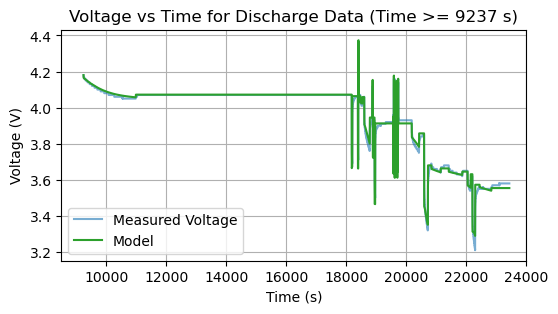

In [63]:
fig = plt.subplots(figsize=(6, 3))
plt.plot(BT_discharge['Time (s)'], dis_voltage_array, label='Measured Voltage', alpha=0.6)
plt.plot(BT_discharge['Time (s)'], v_term, label='Model', color='C2')
plt.title('Voltage vs Time for Discharge Data (Time >= 9237 s)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.xlim(8500, 24000)
plt.legend()
plt.grid()
plt.show()

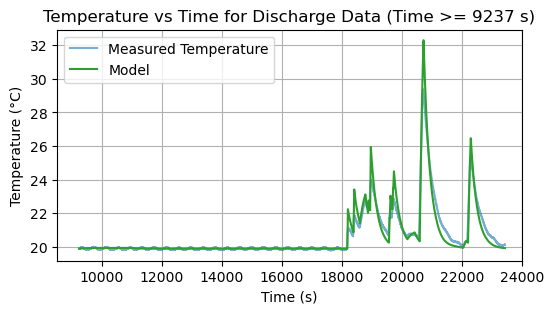

In [64]:
fig = plt.subplots(figsize=(6, 3))
plt.plot(BT_discharge['Time (s)'], BT_discharge['Temperature'], label='Measured Temperature', alpha=0.6)
plt.plot(BT_discharge['Time (s)'], T_cell-273.15, label='Model', color='C2')
plt.title('Temperature vs Time for Discharge Data (Time >= 9237 s)')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.xlim(8500, 24000)
plt.legend()
plt.grid()
plt.show()

#### Error Calculation

RMSE: 0.016 V


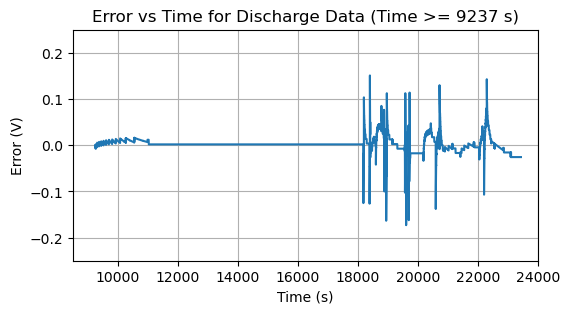

In [65]:
# Error
error_array = v_term - dis_voltage_array
rmse = np.sqrt(np.mean(error_array**2))
print(f'RMSE: {round(rmse, 3)} V')

fig = plt.subplots(figsize=(6, 3))
plt.plot(BT_discharge['Time (s)'], error_array)
plt.title('Error vs Time for Discharge Data (Time >= 9237 s)')
plt.xlabel('Time (s)')
plt.ylabel('Error (V)')
plt.xlim(8500, 24000)
plt.ylim(-0.25, 0.25)
plt.grid()
plt.show()

RMSE: 0.38 °C


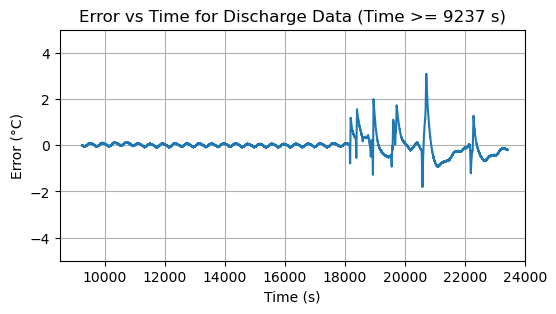

In [66]:
error_array = T_cell - 273.15 - BT_discharge['Temperature'].values
rmse = np.sqrt(np.mean(error_array**2))
print(f'RMSE: {round(rmse, 3)} °C')

fig = plt.subplots(figsize=(6, 3))
plt.plot(BT_discharge['Time (s)'], error_array)
plt.title('Error vs Time for Discharge Data (Time >= 9237 s)')
plt.xlabel('Time (s)')
plt.ylabel('Error (°C)')
plt.xlim(8500, 24000)
plt.ylim(-5, 5)
plt.grid()
plt.show()

In [67]:
# Iterate to find optimal h
from scipy.optimize import minimize

def cost(h):
    
    # Find initial temperature of cell
    T_cell = np.zeros(len(BT_discharge))
    T_cell[0] = BT_discharge['Temperature'].iloc[0] + 273.15

    # Parameters
    R0_T0 = 0.01987 # Ω
    E0 = -22693

    R1_0AT0 = 0.035 # Ω
    C1 = 2.814 # kF
    b = -0.6658
    c = 0.09784
    d = 0.00023
    E1 = -27887

    m = 0.042 # kg
    cv = 825 # J/kgK

    A = 0.018*np.pi*0.065 + 2*np.pi*0.065**2/4  # m^2 (surface area of 18650 battery)
    T_amb = np.mean(BT_DATA['Temperature'][5000:9237]) + 273.15 # K

    # Resistance functions
    def get_R0(T_cell): # T_cell in K, R0 in Ω
        return R0_T0 * np.exp(-E0/8.314*(1/T_cell-1/T_amb))

    def get_R1(T_cell, i_R1): # T_cell in K, i_R1 in A, R1 in Ω
        return 0.0098 + d*i_R1 + R1_0AT0 * np.exp((-1*(i_R1-b)**2)/c) * np.exp(-E1/8.314*(1/T_cell-1/T_amb))

    i_R0 = -BT_discharge['Current (mA)'].values / 1000
    R0 = np.zeros(len(BT_discharge))
    R0[0] = get_R0(T_cell[0])
    # print(f'Initial R0 = {np.round(R0[0], 3)} Ω')

    i_R1 = np.zeros(len(BT_discharge))
    R1 = np.zeros(len(BT_discharge))
    R1[0] = get_R1(T_cell[0], i_R1[0])
    # print(f'Initial R1 = {np.round(R1[0], 3)} Ω')

    SOC_array = charge_array/CAPACITY_C * 100
    OCV_array = get_OCV(SOC_array)

    v_term = np.zeros(len(BT_discharge))
    v_term[0] = BT_discharge['Voltage (V)'].iloc[0]
    # print(f'Initial v_term = {np.round(v_term[0], 2)} V')

    DT = 1 # s
    for i in range(0, len(BT_discharge) - 1):
        T_cell[i+1] = T_cell[i] + DT / (m*cv) * (R0[i]*i_R0[i]**2 + R1[i]*i_R1[i]**2 - h*A*(T_cell[i]-T_amb))
        i_R1[i+1] = np.exp(-1*DT/(R1[i]*C1)) * i_R1[i] + (1 - np.exp(-1*DT/(R1[i]*C1))) * i_R0[i]
        R0[i+1] = get_R0(T_cell[i+1])
        R1[i+1] = get_R1(T_cell[i+1], i_R1[i+1])
        v_term[i+1] = OCV_array[i+1] - i_R1[i+1]*R1[i+1] - i_R0[i+1]*R0[i+1]
        
    error_array = T_cell - (BT_discharge['Temperature'].values + 273.15)
    mse = np.sqrt(np.mean(error_array**2))
    
    return mse

# print result every iteration
result = minimize(cost, 10, method='Nelder-Mead', callback=lambda xk: print(f"h: {round(xk[0], 5)} W/m^2K"))
print(f"Optimal h: {round(result.x[0], 5)} W/m^2K")

h: 11.5 W/m^2K
h: 13.5 W/m^2K
h: 15.5 W/m^2K
h: 15.5 W/m^2K
h: 16.0 W/m^2K
h: 15.75 W/m^2K
h: 15.75 W/m^2K
h: 15.75 W/m^2K
h: 15.75 W/m^2K
h: 15.76562 W/m^2K
h: 15.76562 W/m^2K
h: 15.76172 W/m^2K
h: 15.76172 W/m^2K
h: 15.76172 W/m^2K
h: 15.76172 W/m^2K
h: 15.76196 W/m^2K
h: 15.76196 W/m^2K
h: 15.7619 W/m^2K
h: 15.7619 W/m^2K
Optimal h: 15.7619 W/m^2K
